In [1]:
import pickle
import numpy as np
import scipy.stats as stats
import math
import json

In [2]:
model = "Qwen3-14B"

In [3]:
with open("/data/home/vkropoti/sql_data/mini-dev-index", "rb") as fp:   # Unpickling
    mini_dev_index = np.array(pickle.load(fp))
    
def load_json():
    with open('/home/vkropoti/vllm/dev.json', "r") as j:
        contents = json.loads(j.read())
    return contents

def load_split():
    data = load_json()
    query_level = []
    for k in range(len(data)):
        query_level.append(data[k]['difficulty'])
    return np.array(query_level)

In [4]:
split = load_split()

In [5]:
np.mean(split=='simple')

np.float64(0.6029986962190352)

In [6]:
np.mean(split=='moderate')

np.float64(0.30247718383311606)

In [7]:
np.mean(split=='challenging')

np.float64(0.09452411994784876)

In [8]:
def I_alpha(mean,n,std_dev,confidence = 0.95):
    # Критическое значение t для 95% ДИ и 49 степеней свободы
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin_of_error = t_value * (std_dev / math.sqrt(n))
    
    # Границы доверительного интервала
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
    return ci_lower, ci_upper

In [9]:
def load_results(k,nobs,cot_type,think=False):
    # sql_results_Qwen3-8B-cot_all_new_think==False_nobs2-v0
    # with open(f"/data/home/vkropoti/sql_llm_answers/base_reasoning/sql_results_{model}-cot_{type_cot}_think=={use_think}-v{k}", "rb") as fp:
    with open(f"/data/home/vkropoti/sql_llm_answers/bird_dev_m_schema/sql_results_Qwen3-14B-cot_{cot_type}_think=={think}_nobs{nobs}-v{k}", "rb") as fp:
        results = np.array(pickle.load(fp))
    return results

In [10]:
def load_executed(k,nobs,cot_type,think=False):
    # /data/home/vkropoti/sql_llm_answers/base_reasoning/sql_executed_{model}-cot_{type_cot}_think=={use_think}-v{version}
    with open(f"/data/home/vkropoti/sql_llm_answers/bird_dev_m_schema/sql_executed_Qwen3-14B-cot_{cot_type}_think=={think}_nobs{nobs}-v{k}", "rb") as fp:
        executed = np.array(pickle.load(fp))
    return executed

In [11]:
def get_think_results(n,nobs=2,cot_type='all_new',think=False):
    
    arr_mean_scores = []
    arr_mean_executed = []
    d_split = {"simple":[], "moderate":[], "challenging":[]}
    for i in range(n):
        result, executed = load_results(i,nobs,cot_type,think), load_executed(i,nobs,cot_type,think)
        arr_mean_scores.append(np.mean(result))
        arr_mean_executed.append(np.mean(executed))
        d_split['simple'].append(np.mean(result[split=='simple']))
        d_split['moderate'].append(np.mean(result[split=='moderate']))
        d_split['challenging'].append(np.mean(result[split=='challenging']))
        
    if cot_type=='all_new':
        add = "данные о размышлениях + финальный ответ"
    elif cot_type=='think':
        add = "только данные о размышлениях"
    elif cot_type=='predict':
        add = "только данные о финальных ответах"

    ci_lower, ci_upper = I_alpha(np.mean(np.array(arr_mean_scores)),n,np.std(np.array(arr_mean_scores)))
    print(f"Модель основывает ответ по {nobs} выводам других моделей, которые включают {add}")
    print(f"Результаты получены прогоном {n} симуляций с разными seed")
    print(f"{model} DEV Финальный результат EX: {np.mean(np.array(arr_mean_scores)):.5f}, при std: {np.std(np.array(arr_mean_scores)):.4f}")
    print(f"95% доверительный интервал: ({ci_lower:.5f},{ci_upper:.5f})")
    for type_ in d_split:
        print(f"{type_}: {np.mean(np.array(d_split[type_])):.5f}")

    d_split['simple'] = np.mean(d_split['simple'])
    d_split['moderate'] = np.mean(d_split['moderate'])
    d_split['challenging'] = np.mean(d_split['challenging'])
    # print(f"{model} процент запросов, которые успешно выполнились DEV: {np.mean(np.array(arr_mean_executed)):.4f}, при std: {np.std(np.array(arr_mean_executed)):.4f}")
    return np.mean(np.array(arr_mean_scores)), d_split
    # print(f"{model} процент запросов, которые успешно выполнились Mini DEV: {np.mean(np.array(arr_mean_executed)):.4f}, при std: {np.std(np.array(arr_mean_executed)):.4f}")
    

## Использование reasoning+ответ

In [12]:
scores = []
scores_split = [] 
for n in range(2,6):
    score, score_split = get_think_results(20,nobs=n,cot_type='all_new')
    scores.append(score)
    scores_split.append(score_split)
    print()

Модель основывает ответ по 2 выводам других моделей, которые включают данные о размышлениях + финальный ответ
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.62207, при std: 0.0035
95% доверительный интервал: (0.62044,0.62369)
simple: 0.68416
moderate: 0.55140
challenging: 0.45207

Модель основывает ответ по 3 выводам других моделей, которые включают данные о размышлениях + финальный ответ
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.62295, при std: 0.0045
95% доверительный интервал: (0.62084,0.62505)
simple: 0.68541
moderate: 0.55312
challenging: 0.44793

Модель основывает ответ по 4 выводам других моделей, которые включают данные о размышлениях + финальный ответ
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.62425, при std: 0.0048
95% доверительный интервал: (0.62200,0.62650)
simple: 0.68600
moderate: 0.55345
challenging: 0.45690

Моде

## Использование только ответ

In [13]:
scores_predict = []
scores_split_predict = [] 
for n in range(2,6):
    score, score_split = get_think_results(20,nobs=n,cot_type='predict')
    scores_predict.append(score)
    scores_split_predict.append(score_split)
    print()

Модель основывает ответ по 2 выводам других моделей, которые включают только данные о финальных ответах
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.61871, при std: 0.0047
95% доверительный интервал: (0.61653,0.62089)
simple: 0.68119
moderate: 0.54698
challenging: 0.44966

Модель основывает ответ по 3 выводам других моделей, которые включают только данные о финальных ответах
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.62331, при std: 0.0031
95% доверительный интервал: (0.62185,0.62476)
simple: 0.68551
moderate: 0.55313
challenging: 0.45103

Модель основывает ответ по 4 выводам других моделей, которые включают только данные о финальных ответах
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.62513, при std: 0.0048
95% доверительный интервал: (0.62287,0.62739)
simple: 0.68670
moderate: 0.55625
challenging: 0.45276

Модель основывает отве

## Использование только размышлений

In [29]:
scores_think = []
scores_split_think = [] 
for n in range(2,4):
    score, score_split = get_think_results(20,nobs=n,cot_type='think')
    scores_think.append(score)
    scores_split_think.append(score_split)
    print()

Модель основывает ответ по 2 выводам других моделей, которые включают только данные о размышлениях
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.61851, при std: 0.0061
95% доверительный интервал: (0.61568,0.62135)
simple: 0.68405
moderate: 0.54558
challenging: 0.43379

Модель основывает ответ по 3 выводам других моделей, которые включают только данные о размышлениях
Результаты получены прогоном 20 симуляций с разными seed
Qwen3-14B DEV Финальный результат EX: 0.62053, при std: 0.0052
95% доверительный интервал: (0.61809,0.62298)
simple: 0.68551
moderate: 0.54881
challenging: 0.43552



In [15]:
# get_think_results(20,nobs=6,cot_type='think')

In [16]:
# get_think_results(20,nobs=7,cot_type='think')

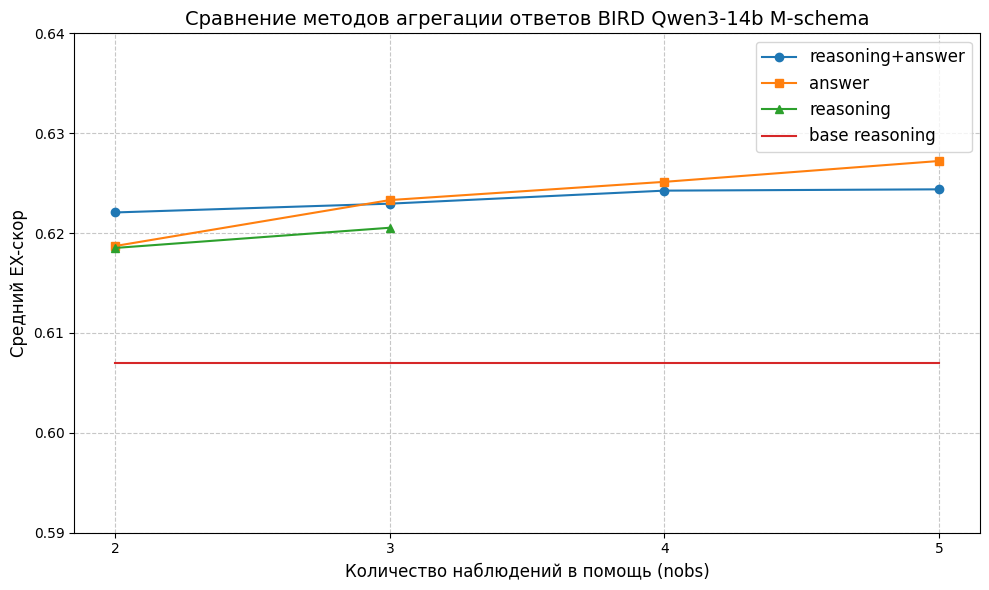

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Данные
nobs = [2, 3, 4, 5]
base_think = [0.607]*4
# Создание графика
plt.figure(figsize=(10, 6))
plt.plot(nobs, scores, marker='o', label='reasoning+answer', color='tab:blue')
plt.plot(nobs, scores_predict, marker='s', label='answer', color='tab:orange')
plt.plot(nobs[0:2], scores_think, marker='^', label='reasoning', color='tab:green')
plt.plot(nobs, base_think, label='base reasoning', color='tab:red')

# Настройки
plt.title('Сравнение методов агрегации ответов BIRD Qwen3-14b M-schema', fontsize=14)
plt.xlabel('Количество наблюдений в помощь (nobs)', fontsize=12)
plt.ylabel('Средний EX-скор', fontsize=12)
plt.xticks(nobs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.ylim(0.59, 0.64)  # Фиксируем диапазон для лучшего сравнения

# Отображение
plt.tight_layout()
plt.show()

In [23]:
def plot_split(type_, lowe_bound=0, upper_bound=1):
    scores = [x[type_] for x in scores_split]
    scores_predict = [x[type_] for x in scores_split_predict]
    scores_think = [x[type_] for x in scores_split_think]
    # Данные
    nobs = [2, 3, 4, 5]
    # base_think = [0.587]*4
    # Создание графика
    plt.figure(figsize=(10, 6))
    plt.plot(nobs, scores, marker='o', label='reasoning+answer', color='tab:blue')
    plt.plot(nobs, scores_predict, marker='s', label='answer', color='tab:orange')
    plt.plot(nobs[0:2], scores_think, marker='^', label='reasoning', color='tab:green')
    # plt.plot(nobs, base_think, label='base reasoning', color='tab:red')
    
    # Настройки
    plt.title(f'Сравнение методов агрегации ответов ({type_}) Qwen3-14b M-schema', fontsize=14)
    plt.xlabel('Количество наблюдений в помощь (nobs)', fontsize=12)
    plt.ylabel('Средний EX-скор', fontsize=12)
    plt.xticks(nobs)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.ylim(lowe_bound, upper_bound)  # Фиксируем диапазон для лучшего сравнения
    plt.grid(visible=True)
    # Отображение
    plt.tight_layout()
    
    plt.show()

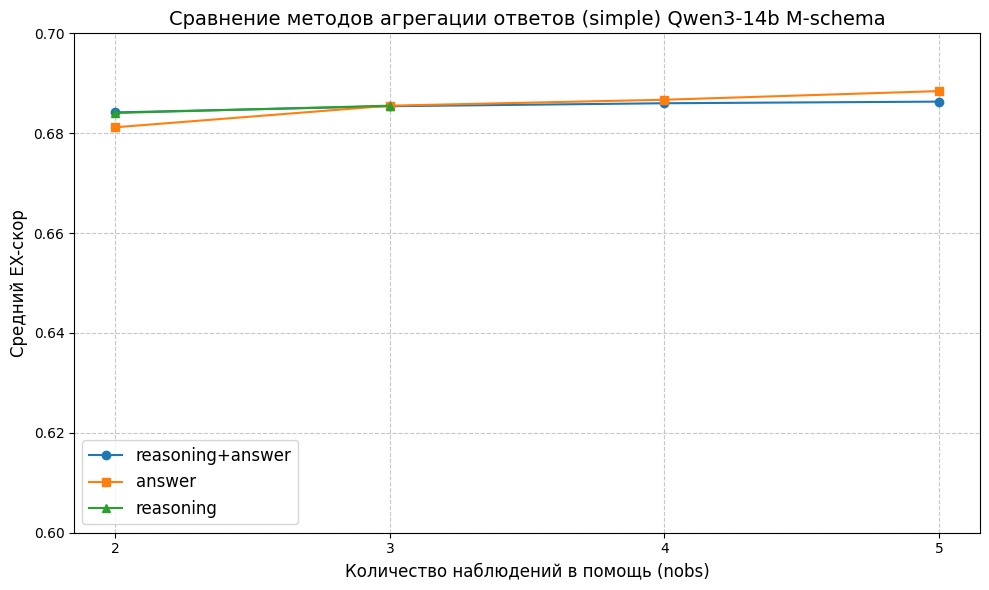

In [24]:
plot_split('simple',0.6,0.7)

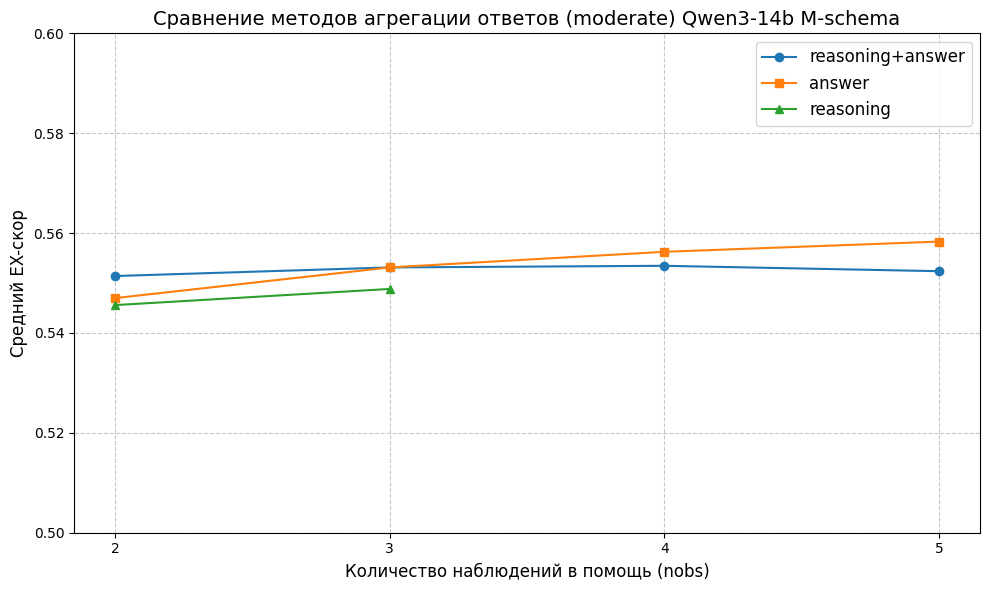

In [25]:
plot_split('moderate',0.5,0.6)

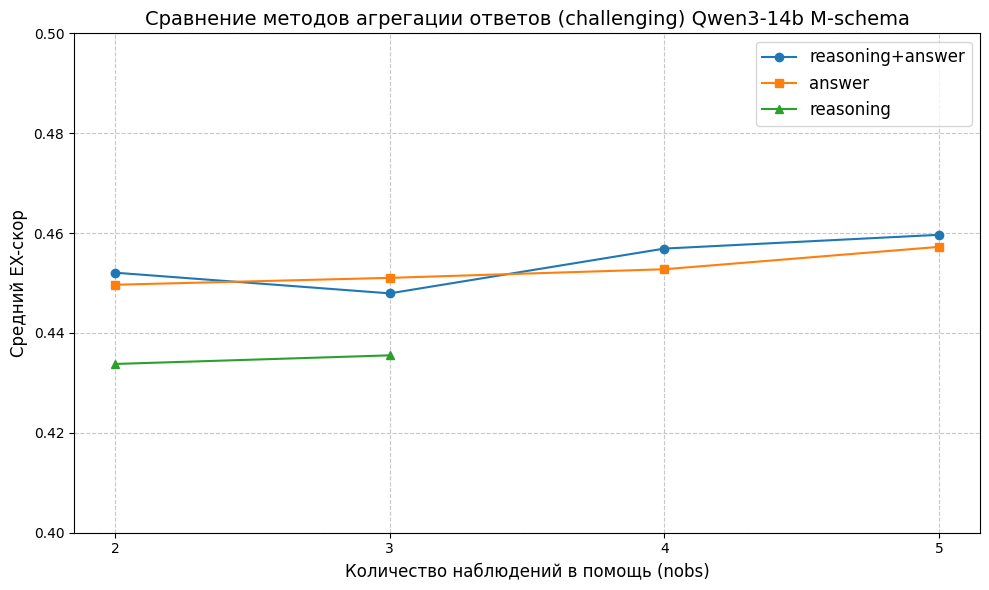

In [26]:
plot_split('challenging',0.4,0.5)